In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import sem, mannwhitneyu, spearmanr
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns
import string
import statsmodels.api as sm
from datetime import datetime, timedelta

In [2]:
os.makedirs("fig", exist_ok=True)

In [3]:
df = pd.read_csv("data/data.csv", index_col=0, )
df = df.drop(df[df.time == "/"].index)
df = df.drop(df[df.video == "/"].index)
df = df.dropna()
df = df.reset_index()
df['date'] = pd.to_datetime(df['date'].apply(str)+' '+ df['time'], format="%d/%m/%Y %H:%M:%S")
df.rename(columns={"date": "datetime"}, inplace=True)
df.drop("time", inplace=True, axis=1)
# df.date = pd.to_datetime(df.date, infer_datetime_format=True)
# df.time = pd.to_datetime(df.time, infer_datetime_format=True).apply(lambda x: x.time())
df.seconds = pd.to_numeric(df.seconds)
df.day = pd.to_numeric(df.day)
df

,day,datetime,seconds,video
0,1,2021-08-14 11:02:20,6,Over Dubai
1,1,2021-08-14 19:41:28,41,Abstract - Canyon
2,3,2021-08-16 11:08:39,5,Dog POV
3,4,2021-08-17 11:49:42,642,Black hole video
4,4,2021-08-17 19:16:06,500,Two guys on a boat
...,...,...,...,...
361,169,2022-02-19 19:54:34,2,Abstract - Canyon
362,169,2022-02-19 19:56:38,10,Beach video
363,169,2022-02-19 20:05:50,6,Temple
364,169,2022-02-19 21:13:47,8,Shower falls


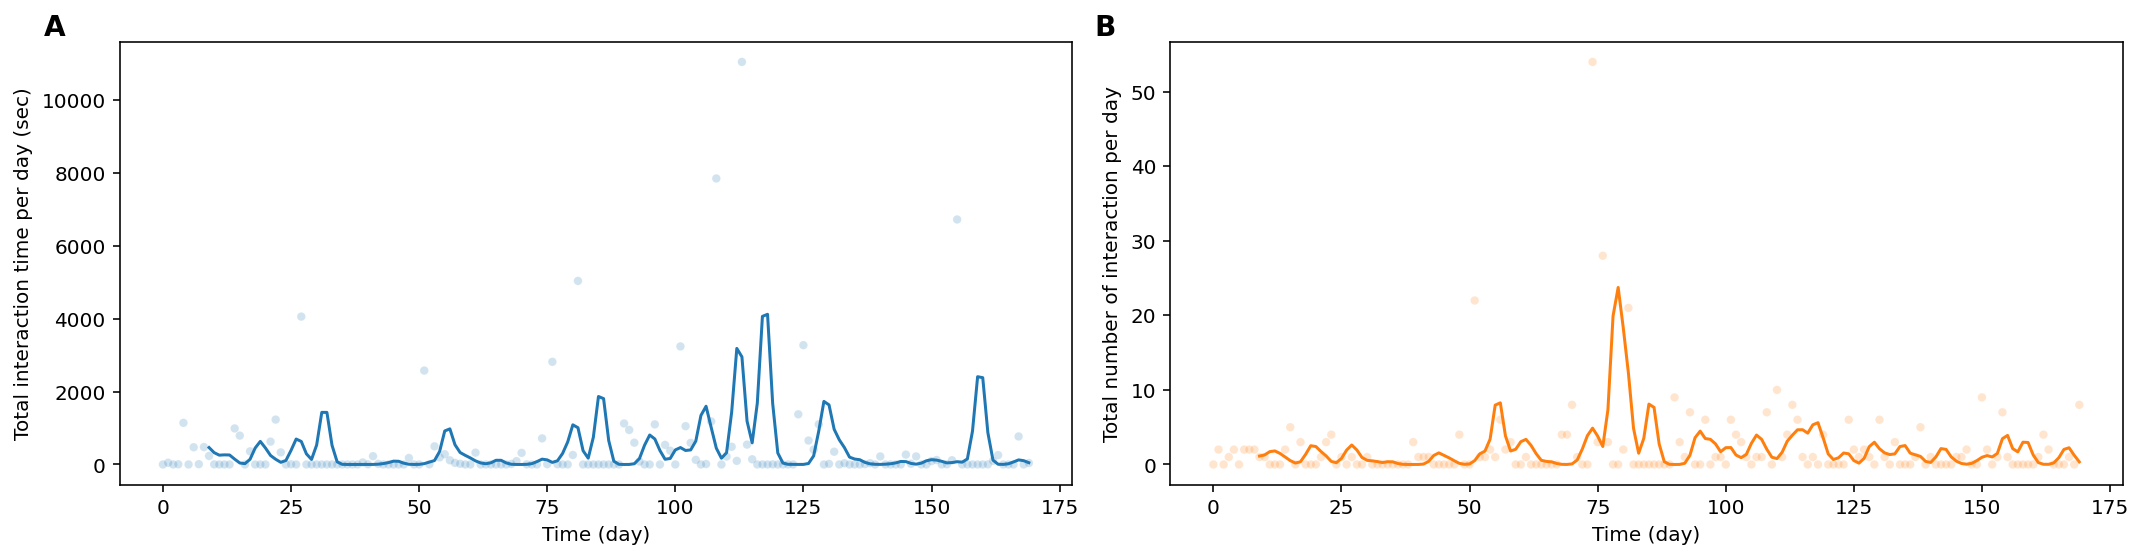

In [4]:
# fig, ax = plt.subplots()
# sns.histplot(ax=ax, data=df, x="day", kde=False, bins=30)
# ax.set_xlabel("Time (day)")
# ax.set_ylabel("Average number of interaction")
fig, axes = plt.subplots(ncols=2, figsize=(15, 4))

ax = axes[0]

x = np.arange(170)
y = np.zeros(170)
series = df.groupby(df.day)["seconds"].sum()
y[series.index] = series.to_numpy()

sns.scatterplot(ax=ax, x=x, y=y, size=1, alpha=0.2, legend=False)
pd.Series(y).rolling(10, win_type='gaussian').mean(std=1.0).plot(ax=ax)

ax.set_xlabel("Time (day)")
ax.set_ylabel("Total interaction time per day (sec)");

ax = axes[1]

x = np.arange(170)
y = np.zeros(170)
series = df.groupby(df.day)["seconds"].count()
y[series.index] = series.to_numpy()

sns.scatterplot(ax=ax, x=x, y=y, size=1, alpha=0.2, legend=False, color="C1")
pd.Series(y).rolling(10, win_type='gaussian').mean(std=1.0).plot(ax=ax, color="C1")

ax.set_xlabel("Time (day)")
ax.set_ylabel("Total number of interaction per day")

for ax, letter in zip(axes, string.ascii_uppercase):
    ax.text(-0.08, 1, letter, fontsize=14, fontweight="bold", va="bottom", ha="left",
           transform=ax.transAxes)
    
plt.tight_layout()
plt.savefig("fig/per_day.pdf")

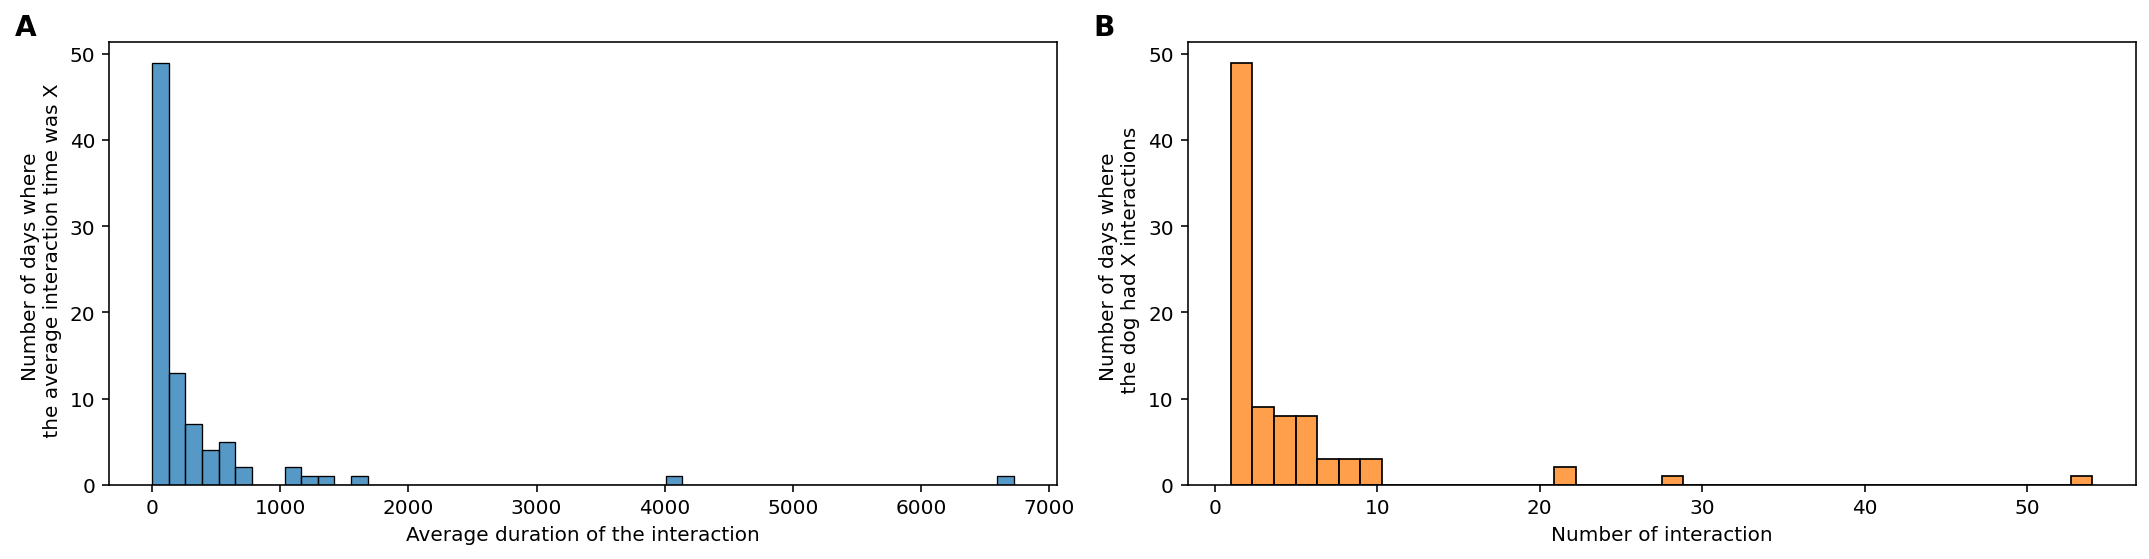

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 4))

ax = axes[0]

sns.histplot(ax=ax, x=df.groupby(df.day)["seconds"].mean())
ax.set_xlabel("Average duration of the interaction")
ax.set_ylabel("Number of days where \n the average interaction time was X");

ax = axes[1]

x = df.groupby(df.day)["seconds"].count()
sns.histplot(ax=ax, x=x, color="C1")
ax.set_xlabel("Number of interaction")
ax.set_ylabel("Number of days where \n the dog had X interactions")

for ax, letter in zip(axes, string.ascii_uppercase):
    ax.text(-0.1, 1, letter, fontsize=14, fontweight="bold", va="bottom", ha="left",
           transform=ax.transAxes)
    
plt.tight_layout()
plt.savefig("fig/dist.pdf")

In [6]:
# fig, ax = plt.subplots(figsize=(15, 5))
# import datetime as dt
# from matplotlib import dates
# x = []
# for index, datetime in enumerate(df.datetime):
#     x.append(dt.datetime.combine(dt.date(2017, 1, 1), datetime.time()))
# sns.histplot(ax=ax, x=x, kde=False, bins=30)
# ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M:%S'))
# ax.set_ylabel("Number of interaction");

In [7]:
# df.groupby(df["datetime"].dt.hour)["seconds"].count().plot.bar();

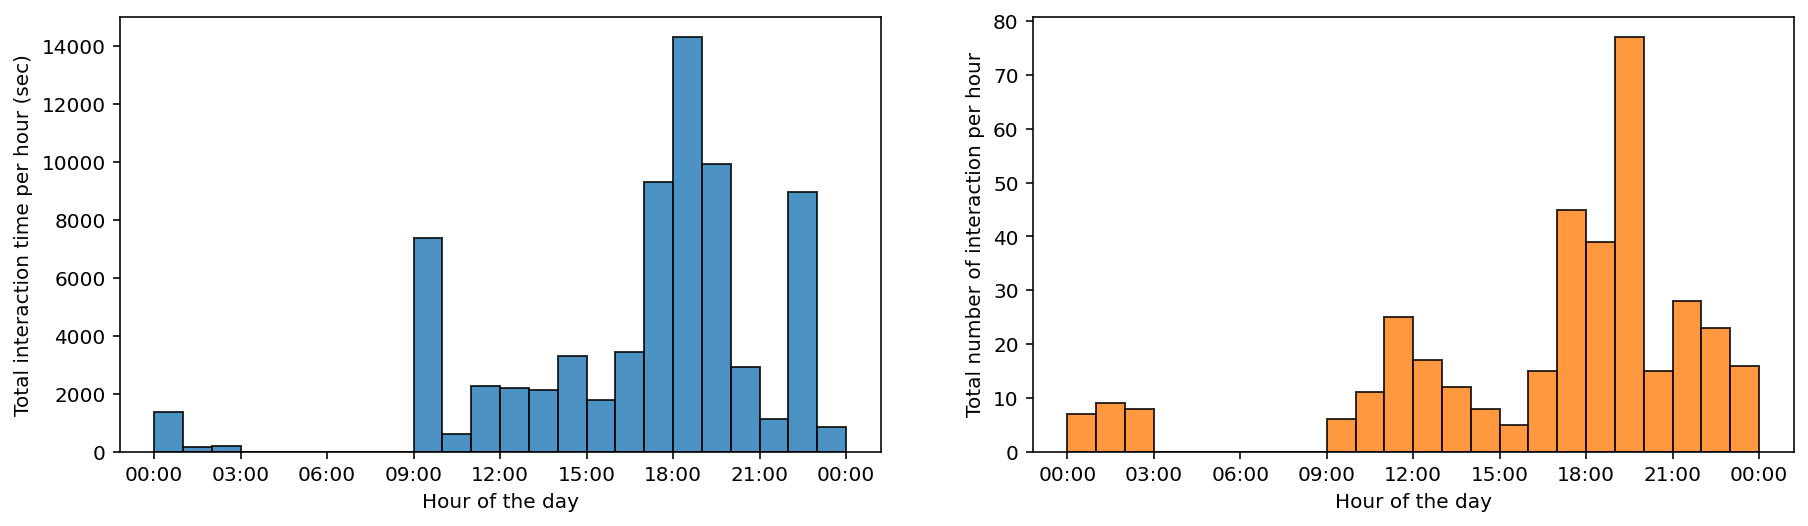

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 4))

ax = axes[0]

ts = [datetime(9999, 1, 1, i) for i in range(24)]

y__ = df.groupby(df["datetime"].dt.hour)["seconds"].sum()

y = np.zeros(24)
y[y__.index] = y__.values

# y_sem = np.zeros(24)
# y_sem[y__.index] = y__["sem"].values 

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.bar(x=ts, height=y, width=timedelta(hours=1), align='edge', edgecolor='black', alpha=0.8, color='C0')
       # yerr=y_sem);
ax.set_xlabel("Hour of the day")
ax.set_ylabel("Total interaction time per hour (sec)")

# ------------ #

ax = axes[1]

y__ = df.groupby(df["datetime"].dt.hour)["seconds"].count()

y = np.zeros(24)
y[y__.index] = y__.values 

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.bar(x=ts, height=y, width=timedelta(hours=1), align='edge', edgecolor='black', alpha=0.8, color="C1")

ax.set_xlabel("Hour of the day")
ax.set_ylabel("Total number of interaction per hour");

In [9]:
df["hour"] = df.datetime.dt.hour

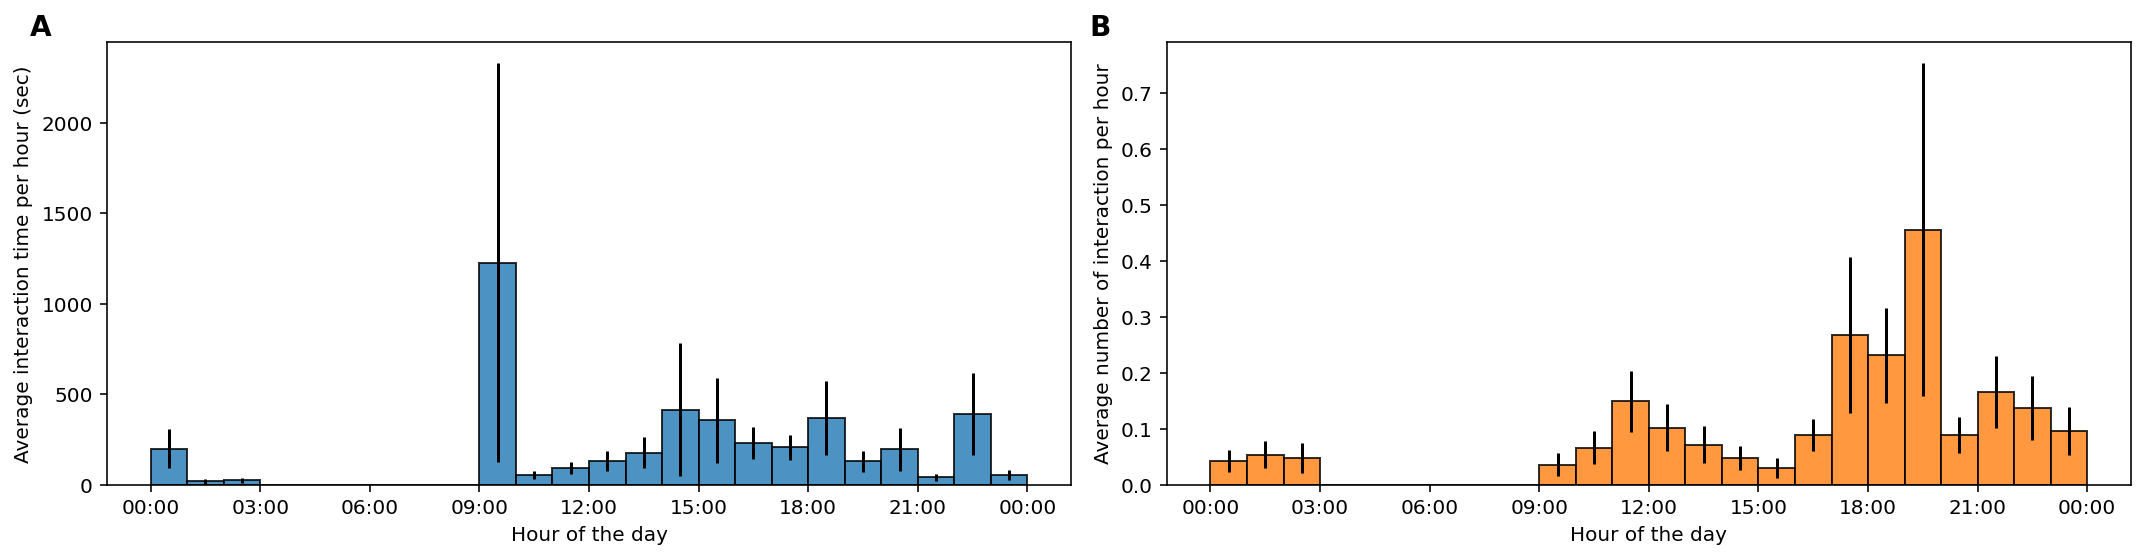

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 4))

ax = axes[0]

ts = [datetime(9999, 1, 1, i) for i in range(24)]

y__ = df.groupby(df["datetime"].dt.hour)["seconds"].agg([np.mean, sem])

y = np.zeros(24)
y[y__.index] = y__["mean"].values

y_sem = np.zeros(24)
y_sem[y__.index] = y__["sem"].values 

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.bar(x=ts, height=y, width=timedelta(hours=1), align='edge', edgecolor='black', alpha=0.8, color='C0',
       yerr=y_sem)
ax.set_xlabel("Hour of the day")
ax.set_ylabel("Average interaction time per hour (sec)")

# ------------ #

ax = axes[1]

df_count = pd.DataFrame(df.groupby(["day", "hour"])["seconds"].count())
df_count.rename(columns={"seconds": "n_interaction"}, inplace=True)
df_count.reset_index(inplace=True)

to_add = []
for day in range(1, df.day.max()):
    for hour in range(24):
        if not len(df_count[(df_count.day == day) & (df_count.hour == hour)].index):
            to_add.append({"day": day, "hour": hour, "n_interaction": 0})
    
df_count = pd.concat((df_count, pd.DataFrame(to_add)))
df_count.sort_values(["day", "hour"], inplace=True)

y__ = df_count.groupby("hour")["n_interaction"].agg([np.mean, sem])

y = np.zeros(24)
y[y__.index] = y__["mean"].values 

y_sem = np.zeros(24)
y_sem[y__.index] = y__["sem"].values 

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.bar(x=ts, height=y, width=timedelta(hours=1), align='edge', edgecolor='black', alpha=0.8, color="C1",
       yerr=y_sem)

ax.set_xlabel("Hour of the day")
ax.set_ylabel("Average number of interaction per hour")

for ax, letter in zip(axes, string.ascii_uppercase):
    ax.text(-0.08, 1, letter, fontsize=14, fontweight="bold", va="bottom", ha="left",
           transform=ax.transAxes)

plt.tight_layout()
plt.savefig("fig/per_hour.pdf")

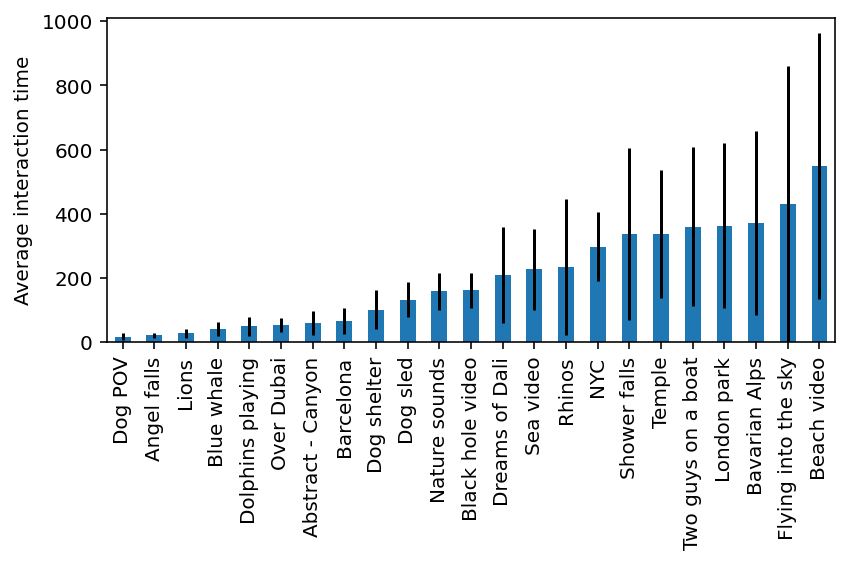

In [11]:
# ax = df.groupby('video')['seconds'].mean().sort_values().plot.bar()
# ax.set_xlabel("")
# ax.set_ylabel("Average duration of the interaction (sec)")
fig, ax = plt.subplots()

avg = df.groupby("video")["seconds"].agg([np.mean, sem])
avg = avg.sort_values("mean")
avg.plot(kind = "bar", y = "mean", ylabel="seconds", legend = False,
          yerr = "sem", ax=ax)

ax.set_xlabel("")
ax.set_ylabel("Average interaction time")

plt.tight_layout()

plt.savefig("fig/all_video.pdf")

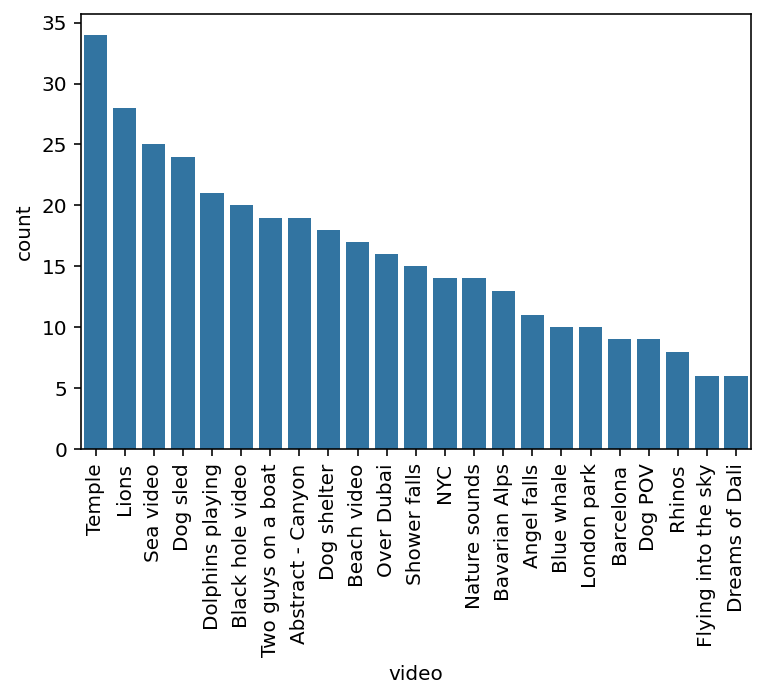

In [12]:
fig, ax = plt.subplots()
# sns.histplot(ax=ax, data=df, x="video")
sns.countplot(x = 'video',
              data = df,
              order = df['video'].value_counts().index, color="C0")
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [13]:
n_video = len(df.video.unique())
n_video

23

In [14]:
df_labels = pd.read_csv("data/video_labels_05072022.csv")
df_labels

,video,camera_movement,content_movement,color,content_type
0,Abstract - Canyon,fast,fast,changing,abstract
1,Angel falls,slow,slow,changing,nature
2,Bavarian Alps,still,fast,static,nature
3,Barcelona,cut,medium,changing,city
4,Beach video,slow,slow,static,nature
5,Black hole video,slow,slow,static,abstract
6,Blue whale,still,fast,static,animal
7,Dog POV,fast,fast,changing,animal
8,Dog shelter,cut,medium,changing,animal
9,Dog sled,slow,fast,static,animal


In [15]:
video_list = df.video.unique()
video_labels = np.asarray(df_labels.video)

# Check that there is not typo
for v in video_list:
    if v not in video_labels:
        print(v)

In [16]:
label_categories = df_labels.columns.to_list()[1:]
label_categories

['camera_movement', 'content_movement', 'color', 'content_type']

In [17]:
df_labels[df_labels["video"]== "Over Dubai"]["camera_movement"].values[0]

'fast'

In [18]:
for index, row in df.iterrows():
    for cat in label_categories:
        label = df_labels[df_labels["video"] == row.video][cat].values[0]
        df.loc[index, cat] = label

In [19]:
df

,day,datetime,seconds,video,hour,camera_movement,content_movement,color,content_type
0,1,2021-08-14 11:02:20,6,Over Dubai,11,fast,slow,static,sky
1,1,2021-08-14 19:41:28,41,Abstract - Canyon,19,fast,fast,changing,abstract
2,3,2021-08-16 11:08:39,5,Dog POV,11,fast,fast,changing,animal
3,4,2021-08-17 11:49:42,642,Black hole video,11,slow,slow,static,abstract
4,4,2021-08-17 19:16:06,500,Two guys on a boat,19,medium,medium,changing,water
...,...,...,...,...,...,...,...,...,...
361,169,2022-02-19 19:54:34,2,Abstract - Canyon,19,fast,fast,changing,abstract
362,169,2022-02-19 19:56:38,10,Beach video,19,slow,slow,static,nature
363,169,2022-02-19 20:05:50,6,Temple,20,slow,medium,changing,nature
364,169,2022-02-19 21:13:47,8,Shower falls,21,still,fast,static,nature


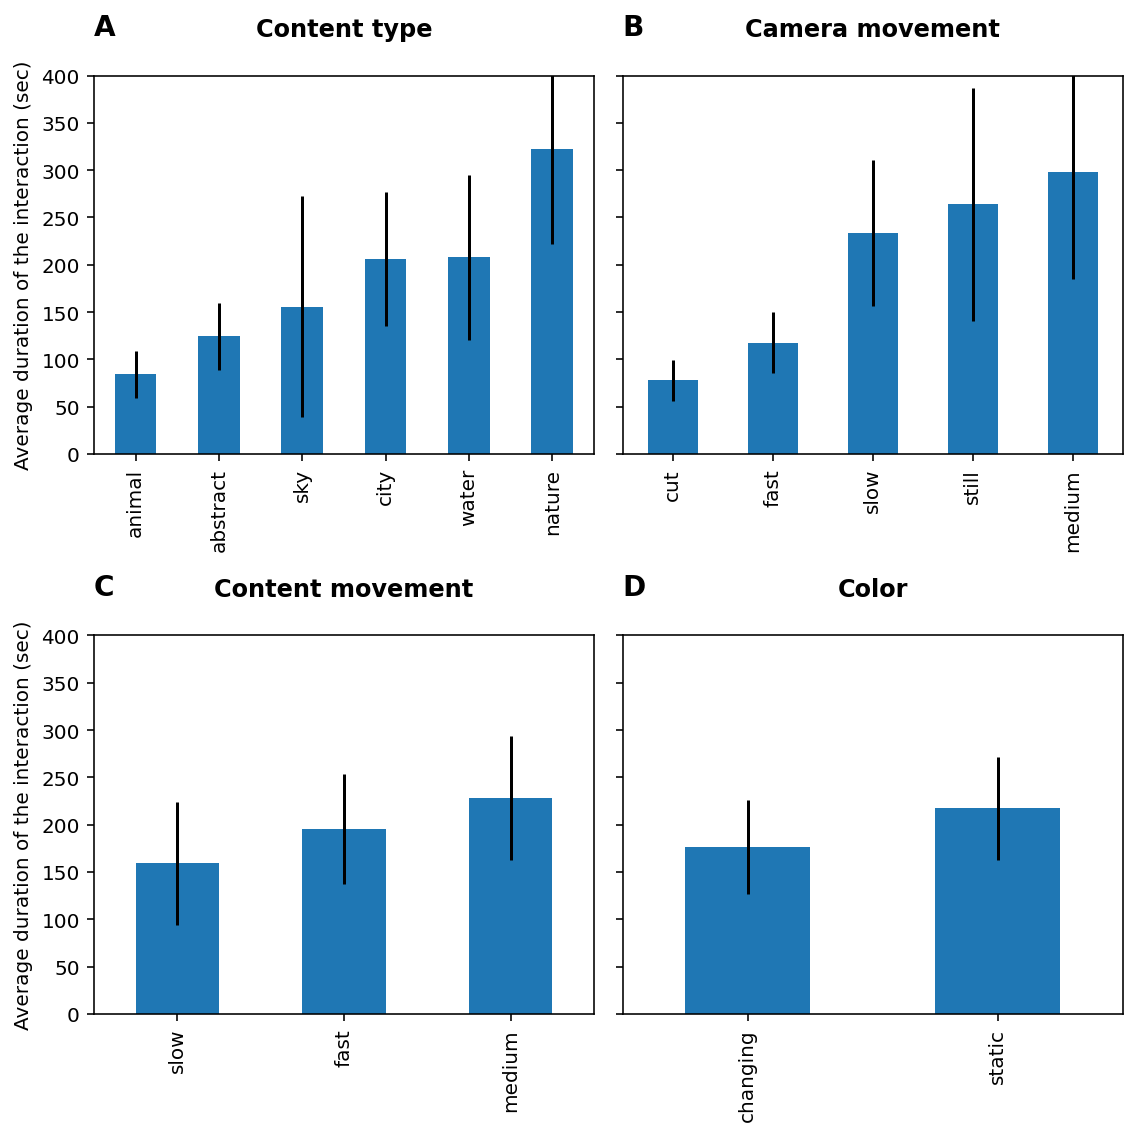

In [38]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8))
axes = axes.flatten()

label_categories.remove("content_type")
label_categories.insert(0, "content_type")

for i, cat in enumerate(label_categories):
    ax = axes[i] 
    qual = df.groupby(cat)["seconds"].agg([np.mean, sem])
    qual = qual.sort_values("mean")
    qual.plot(kind = "bar", y = "mean", ylabel="seconds", legend = False,
              yerr = "sem", ax=ax)
    
    feature_name = cat.replace("_", " ").capitalize() + "\n"
    ax.set_title(feature_name, fontweight='bold')
    ax.set_xlabel("")
    if i % 2 == 0:
        ax.set_ylabel("Average duration of the interaction (sec)")
    else:
        ax.set_yticklabels("")
        ax.set_ylabel("")
    ax.set_ylim(0, 400)

for ax, letter in zip(axes, string.ascii_uppercase):
    if i % 2 == 0:
        lat_pos = - 0.08    
    else:
        lat_pos = - 0.0    
        
    ax.text(lat_pos, 1.09, letter, fontsize=14, fontweight="bold", va="bottom", ha="left",
            transform=ax.transAxes)

plt.tight_layout()

plt.savefig("fig/features.pdf")

In [31]:
cat = "color"
modalities = "changing", "static"
x1 = df[df[cat] == modalities[0]].seconds.values
x2 = df[df[cat] == modalities[1]].seconds.values
# print(f"N={len(x1) + len(x2) } ({len(x1)} + {len(x2)})")
u, p = mannwhitneyu(x1, x2)
n = len(x1) + len(x2)
print(f"$U={u}$, $p={p:.4f}$, $N={len(x1) + len(x2)}$")

$U=16003.5$, $p=0.4646$, $N=366$


In [32]:
cat = "content_movement"
modalities = "medium", "slow"
x1 = df[df[cat] == modalities[0]].seconds.values
x2 = df[df[cat] == modalities[1]].seconds.values
# print(f"N={len(x1) + len(x2) } ({len(x1)} + {len(x2)})")
u, p = mannwhitneyu(x1, x2)
n = len(x1) + len(x2)
print(f"$U={u}$, $p={p:.4f}$, $N={len(x1) + len(x2)}$")

$U=8660.5$, $p=0.3096$, $N=256$


In [33]:
cat = "camera_movement"
modalities = "cut", "medium"
x1 = df[df[cat] == modalities[0]].seconds.values
x2 = df[df[cat] == modalities[1]].seconds.values
# print(f"N={len(x1) + len(x2) } ({len(x1)} + {len(x2)})")
u, p = mannwhitneyu(x1, x2)
n = len(x1) + len(x2)
print(f"$U={u}$, $p={p:.4f}$, $N={len(x1) + len(x2)}$")

$U=1735.0$, $p=0.5150$, $N=123$


In [34]:
cat = "content_type"
modalities = "animal", "nature"
x1 = df[df[cat] == modalities[0]].seconds.values
x2 = df[df[cat] == modalities[1]].seconds.values
# print(f"N={len(x1) + len(x2) } ({len(x1)} + {len(x2)})")
u, p = mannwhitneyu(x1, x2)
n = len(x1) + len(x2)
print(f"$U={u}$, $p={p:.4f}$, $N={len(x1) + len(x2)}$")

$U=4872.5$, $p=0.1371$, $N=211$


In [35]:
cat = "video"
modalities = "Beach video", "Dog POV"
x1 = df[df[cat] == modalities[0]].seconds.values
x2 = df[df[cat] == modalities[1]].seconds.values
# print(f"N={len(x1) + len(x2) } ({len(x1)} + {len(x2)})")
u, p = mannwhitneyu(x1, x2)
n = len(x1) + len(x2)
print(f"$U={u}$, $p={p:.4f}$, $N={len(x1) + len(x2)}$")

$U=100.0$, $p=0.2138$, $N=26$


In [37]:
cat = "video"
modalities = "Beach video", "Angel falls"
x1 = df[df[cat] == modalities[0]].seconds.values
x2 = df[df[cat] == modalities[1]].seconds.values
# print(f"N={len(x1) + len(x2) } ({len(x1)} + {len(x2)})")
u, p = mannwhitneyu(x1, x2)
n = len(x1) + len(x2)
print(f"$U={u}$, $p={p:.4f}$, $N={len(x1) + len(x2)}$")

$U=113.5$, $p=0.3574$, $N=28$


In [28]:
cat = "video"
modalities = "Lions", "Temple"
x1 = df[df[cat] == modalities[0]].seconds.values
x2 = df[df[cat] == modalities[1]].seconds.values
print("n", len(x1), len(x2))
mannwhitneyu(x1, x2)

n 28 34


MannwhitneyuResult(statistic=384.0, pvalue=0.1941079600126301)

In [29]:
df.seconds.mean()

197.2377049180328

In [30]:
df.seconds.min()

1

In [31]:
df.seconds.max()

7118

Text(0, 0.5, 'Number of interaction')

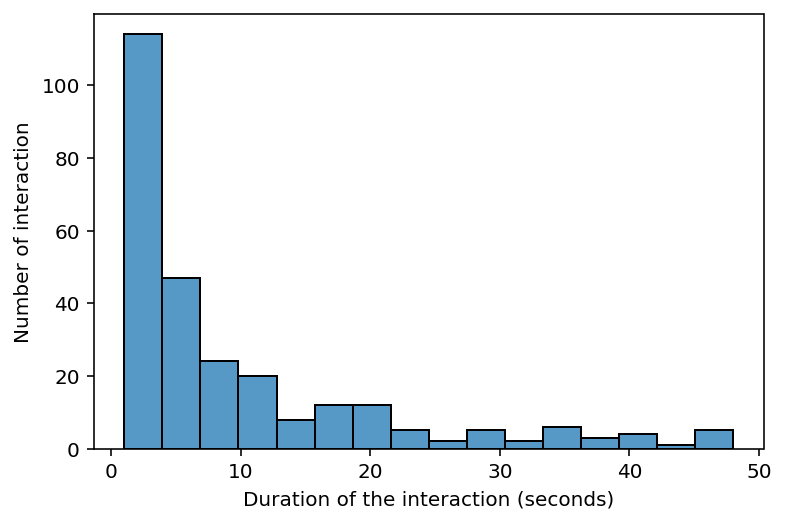

In [32]:
fig, ax = plt.subplots()
sns.histplot(ax=ax, x=df.seconds[df.seconds < 50])
ax.set_xlabel("Duration of the interaction (seconds)")
ax.set_ylabel("Number of interaction")

In [33]:
df_traces = pd.read_csv("traces/traces.csv", index_col=0)
df_traces

,cat,err,learning
0,camera_movement,6.378905,before
1,camera_movement,5.231117,after
2,camera_movement,15.782639,before
3,camera_movement,11.592491,after
4,camera_movement,13.430036,before
...,...,...,...
155,content_type,8.141918,after
156,content_type,7.488688,before
157,content_type,5.389960,after
158,content_type,20.293980,before


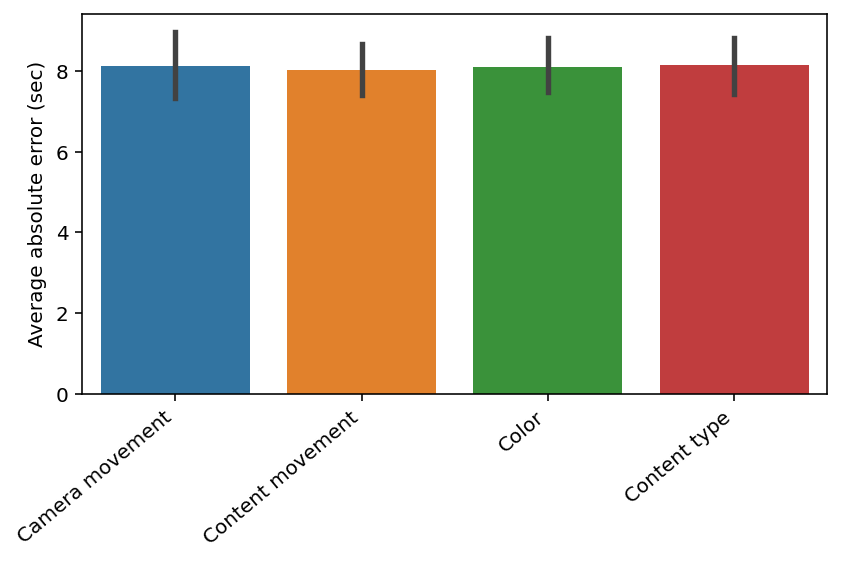

In [34]:
fig, ax = plt.subplots()
sns.barplot(ax=ax, x="cat", y="err", data=df_traces[df_traces.learning == "after"])
labels = [v.get_text() for v in ax.get_xticklabels()]  # get the position and text for each subplot
labels = [v.replace("_", " ").capitalize() for v in labels]

ax.set_ylabel("Average absolute error (sec)")
ax.set_xlabel("")

ax.set_xticklabels(labels, rotation=40, ha="right")

plt.tight_layout()

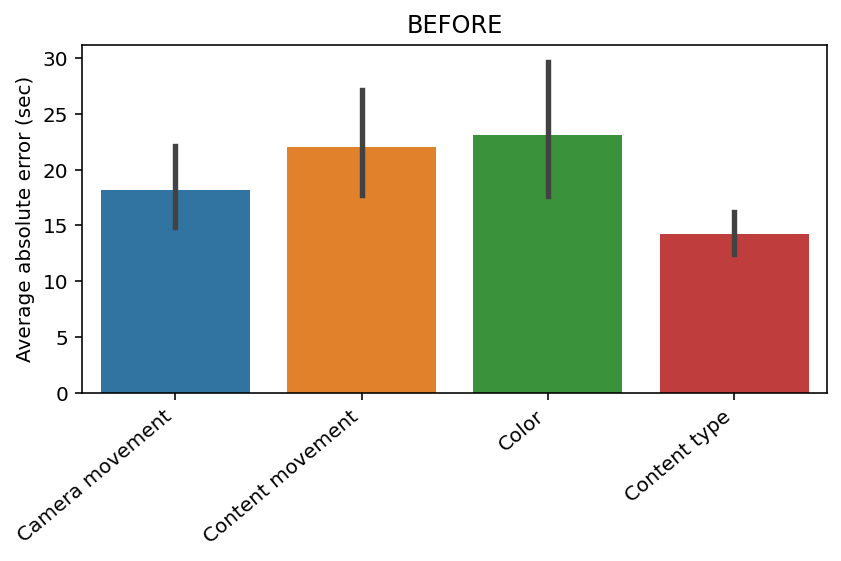

In [35]:
fig, ax = plt.subplots()
sns.barplot(ax=ax, x="cat", y="err", data=df_traces[df_traces.learning == "before"])
labels = [v.get_text() for v in ax.get_xticklabels()]  # get the position and text for each subplot
labels = [v.replace("_", " ").capitalize() for v in labels]

ax.set_ylabel("Average absolute error (sec)")

ax.set_xticklabels(labels, rotation=40, ha="right")

ax.set_title("BEFORE")
ax.set_xlabel("")

plt.tight_layout()

In [37]:
model_lin = sm.OLS.from_formula("seconds ~ camera_movement + content_movement + content_type + color", 
                                data=df)
result_lin = model_lin.fit()
result_lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                seconds   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.7928
Date:                Mon, 15 Aug 2022   Prob (F-statistic):              0.658
Time:                        10:28:10   Log-Likelihood:                -2913.4
No. Observations:                 366   AIC:                             5853.
Df Residuals:                     353   BIC:                             5904.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     68.5832    227.876      0.301      0.764    -379.583     516.749
camera_movement[T.fast]       21.2586    188.277      0.113      0.910    -349.026     391.543
camera_movement[T.medium]    286.2563    215.619      1.328      0.185    -137.804     710.316
camera_movement[T.slow]      132.9771    161.083      0.826      0.410    -183.826     449.780
camera_movement[T.still]     137.0173    239.704      0.572      0.568    -334.410     608.445
content_movement[T.medium]    -7.8895    132.241     -0.060      0.952    -267.968     252.189
content_movement[T.slow]     -15.7875    141.075     -0.112      0.911    -293.240     261.665
content_type[T.animal]       -33.6788    159.104     -0.212      0.832    -346.590     279.232
content_type[T.city]         127.8249    203.665      0.628      0.531    -272.724     528.374
content_type[T.nature]       136.1897    152.991      0.890      0.374    -164.698     437.078
content_type[T.sky]           54.3014    187.775      0.289      0.773    -314.996     423.599
content_type[T.water]        -82.4659    198.506     -0.415      0.678    -472.869     307.937
color[T.static]               -9.9912    108.560     -0.092      0.927    -223.497     203.515
==============================================================================
Omnibus:                      489.334   Durbin-Watson:                   1.816
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43902.049
Skew:                           6.608   Prob(JB):                         0.00
Kurtosis:                      55.002   Cond. No.                         16.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
model_lin = sm.OLS.from_formula("seconds ~ camera_movement*content_movement*content_type*color", 
                                data=df)
result_lin = model_lin.fit()
result_lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                seconds   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.7641
Date:                Mon, 15 Aug 2022   Prob (F-statistic):              0.763
Time:                        10:28:11   Log-Likelihood:                -2909.9
No. Observations:                 366   AIC:                             5864.
Df Residuals:                     344   BIC:                             5950.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================================================
                                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                      82.1249     84.928      0.967      0.334     -84.919     249.169
camera_movement[T.fast]                                                                       -22.1249    105.628     -0.209      0.834    -229.884     185.634
camera_movement[T.medium]                                                                      49.0624     36.230      1.354      0.177     -22.198     120.323
camera_movement[T.slow]                                                                        65.6526     80.840      0.812      0.417     -93.350     224.655
camera_movement[T.still]                                                                        6.7894     36.213      0.187      0.851     -64.437      78.016
content_movement[T.medium]                                                                     11.6459     68.288      0.171      0.865    -122.668     145.960
content_movement[T.slow]                                                                      -17.5439     68.001     -0.258      0.797    -151.295     116.207
content_type[T.animal]                                                                        -30.8278    106.105     -0.291      0.772    -239.524     177.869
content_type[T.city]                                                                           69.3806    120.518      0.576      0.565    -167.665     306.426
content_type[T.nature]                                                                         79.4998     76.856      1.034      0.302     -71.667     230.667
content_type[T.sky]                                                                           122.0483    103.621      1.178      0.240     -81.763     325.860
content_type[T.water]                                                                          28.4859     35.170      0.810      0.419     -40.689      97.661
color[T.static]                                                                                25.1012     49.206      0.510      0.610     -71.682     121.884
camera_movement[T.fast]:content_movement[T.medium]                                          -1.409e-13   1.79e-13     -0.787      0.432   -4.93e-13    2.11e-13
camera_movement[T.medium]:content_movement[T.medium]                                           49.0624     36.230      1.354      0.177     -22.198     120.323
camera_movement[T.slow]:content_movement[T.medium]                                             23.0115     42.927      0.536      0.592     -61.422     107.445
camera_movement[T.still]:content_movement[T

SpearmanrResult(correlation=-0.07568642938526651, pvalue=0.7314253306344033)

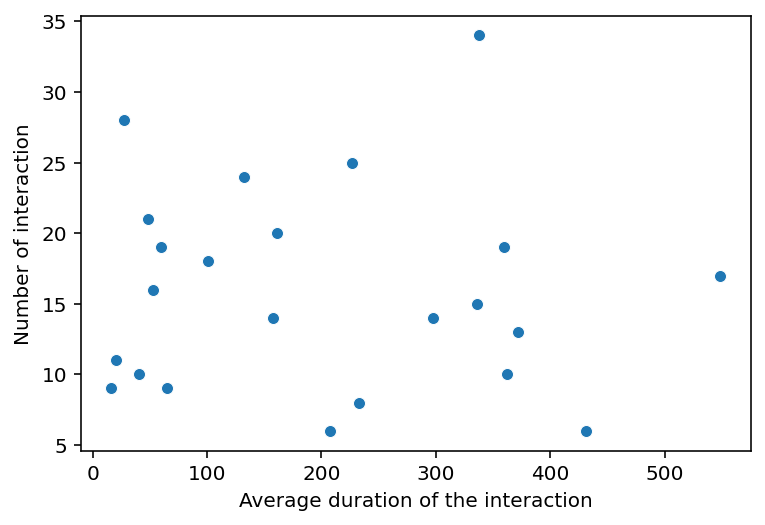

In [61]:
fig, ax = plt.subplots()

x = df.groupby('video')['seconds'].mean()
y = df['video'].value_counts()[x.index]

sns.scatterplot(x=x, y=y, ax=ax);
ax.set_xlabel("Average duration of the interaction")
ax.set_ylabel("Number of interaction")

spearmanr(x, y)

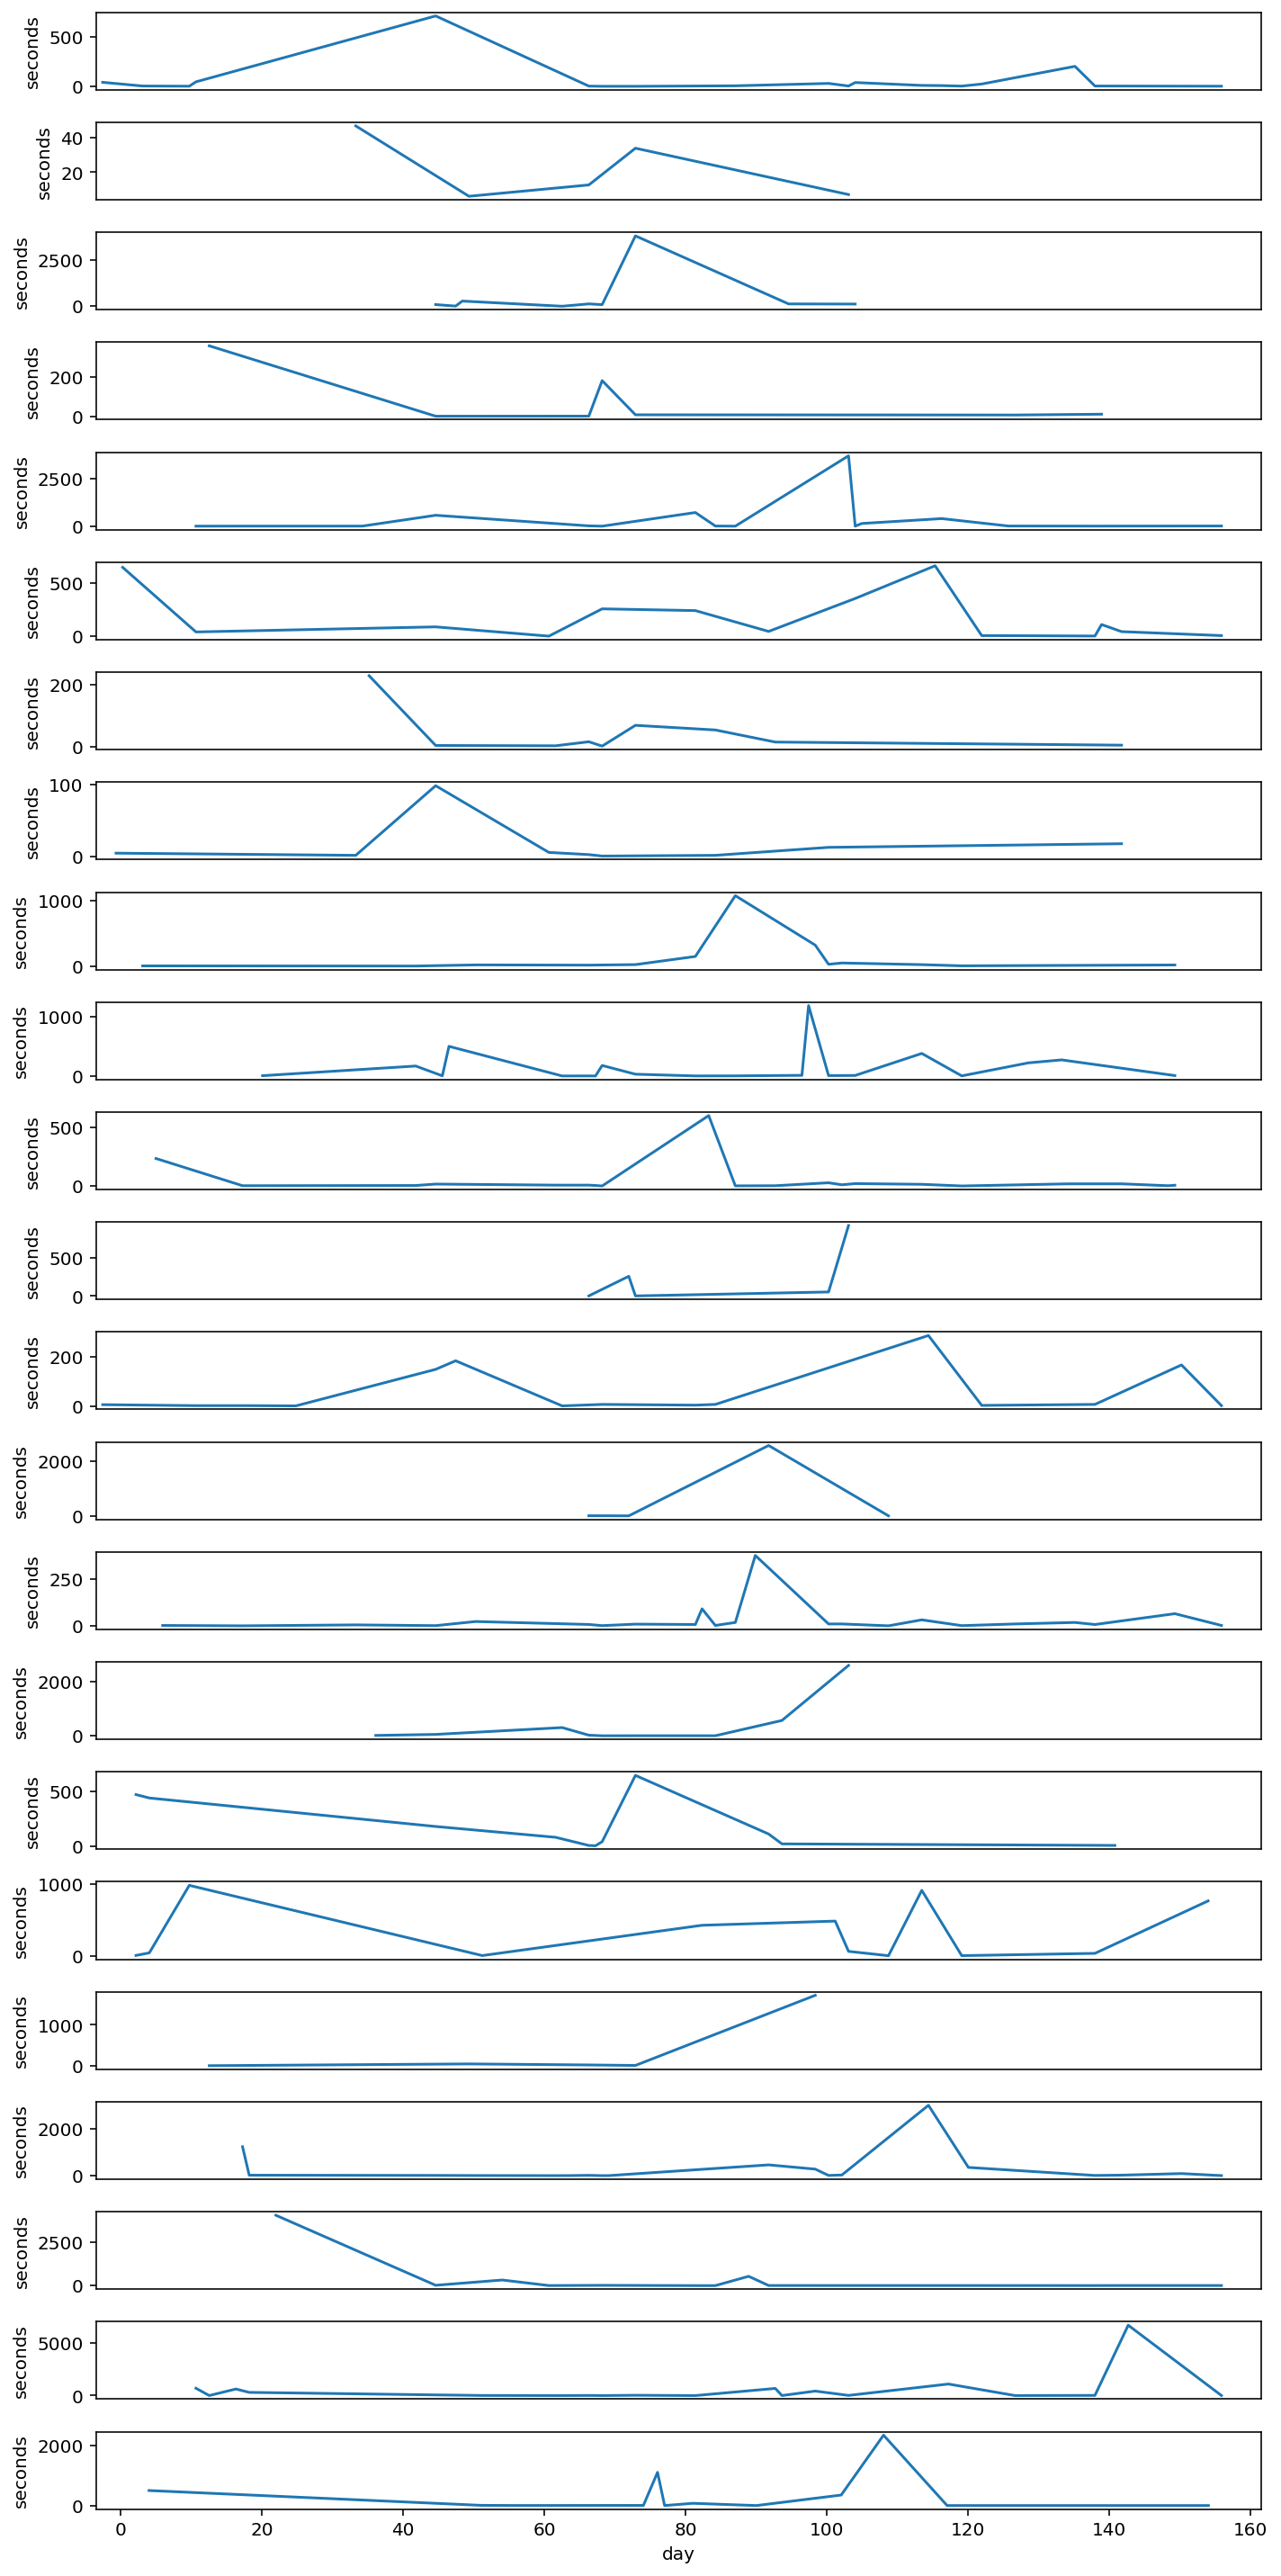

In [70]:
fig, axes = plt.subplots(nrows=n_video, figsize=(10, 20))

for i, video in enumerate(video_labels):
    
    ax = axes[i]
    sns.lineplot(data=df[df.video==video], y="seconds", x="day", legend=False, ax=ax, ci=None)

for ax in axes[:-1]:
    ax.set_xlim(0, 175)
    ax.set_xlabel("")
    ax.set_xticks([])
    
plt.tight_layout()

SpearmanrResult(correlation=-0.14775478308052187, pvalue=0.1720203783645819)

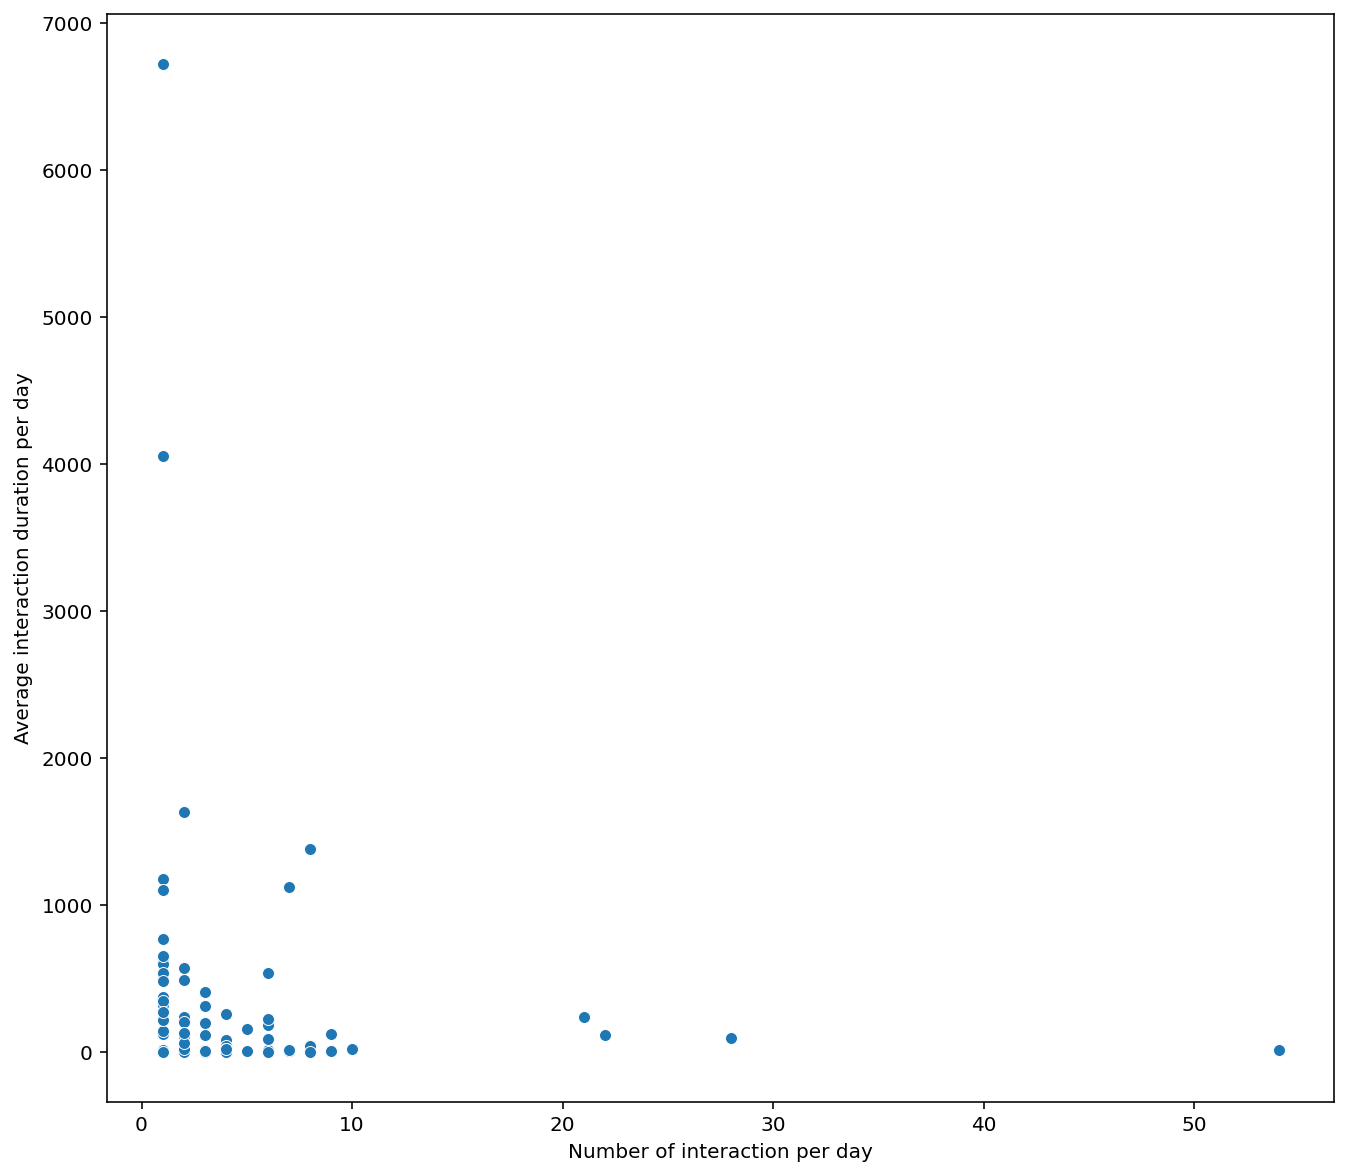

In [60]:
fig, ax = plt.subplots(figsize=(11, 10))

x = df.groupby(df.day)["seconds"].count()
y = df.groupby(df.day)["seconds"].mean()

sns.scatterplot(x=x, y=y, ax=ax)
ax.set_xlabel("Number of interaction per day")
ax.set_ylabel("Average interaction duration per day")

spearmanr(x, y)

In [55]:
sec_per_day = df.groupby(df.day)["seconds"].mean()
f"{sec_per_day.mean():.2f}" + chr(92) + f"pm {sem(sec_per_day):.2f}" 

'342.95\\pm 93.10'

In [57]:
interaction_per_day = df.groupby(df.day)["seconds"].count()
f"{interaction_per_day.mean():.2f}" + chr(92) + f"pm {sem(interaction_per_day):.2f}"

'4.21\\pm 0.75'